# Using machine learning for financial fraud and default prediction

In [54]:
#import all the packages we'll need
import pandas as pd
import numpy  as np
from scipy.stats import chi2_contingency, norm
import statsmodels.api as sm
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.externals.six import StringIO
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Patch
from numpy import interp
from statsmodels.formula.api import ols
import seaborn as sns

import pydotplus
from IPython.display import SVG
from graphviz import Source
from IPython.display import Image
from sympy import var, plot_implicit, Eq

#ignore log(0) and divide by 0 warning
np.seterr(divide = 'ignore');

# Part 1: Supervised Learning

## Introduction (5 min)

This case is split into two parts. This first part focuses on using **supervised learning** to predict loan defaults.

**Business Context.** Online peer-to-peer (P2P) lending has made the practice of borrowing and lending easy. In this form of lending, there is no in-person interview and a borrower can simply fill out an online form and get a loan approved. The information provided solely by a borrower is prone to exaggeration and distortion, especially when it comes to income. Every P2P lending company relies on a well-designed procedure that rejects borrowers with a high chance of not paying off their debts.

Rejecting anyone without a verified source of income is a relevant policy that lending platforms can roll out to help reduce the rate of bad loans. It is natural to suspect that if a person's income source cannot be verified, then they might default on the loan. However, from the perspective of a borrower, the verification process can be cumbersome and time-consuming and they may just switch to another platform due to this inconvenience. However, this single variable likely won't be a highly accurate predictor of loan default probability.  

**Business Problem.** As a data scientist at an emerging P2P lending company, your task is to **build a classification model for determining whether a user will default on their loan or not**.

**Analytical Context.** The data is downloaded from [LendingClub Statistics](https://www.lendingclub.com/info/download-data.action) and it contains all loans issued from 2007 - 2012 along with their current loan status (fully paid or charged off). There are ~50 variables that describe the borrowers and the loans; for the sake of reducing complexity, the company has already performed a pre-screening of these variables based on existing analyses from LendingClub to select nine relevant variables, such as annual income, LendingClub credit grade, home ownership, etc. 

As a data scientist, you need to develop a robust classification algorithm and verify quantitatively that the algorithm is going to work for future data. In this case we'll introduce several new models and model evaluation metrics.

The case is structured as follows: you will   
1) explore the existing data to get a rough idea of how each variable in the dataset interacts with the current loan status  
2) learn about and fit a logistic regression model  
3) learn about model evlauation metrics  
4) learn about and implement Naive Bayes Classifiers and Random Forests  
5) use cross-validation to select the best model 

## Data exploration (35 min)

Before we begin our exploratory analysis, let's take a look at the data at our disposal:

In [2]:
df = pd.read_csv("Lending_club_cleaned_2.csv")
df.loan_status = df.loan_status.astype(pd.api.types.CategoricalDtype(categories=["Charged Off", "Fully Paid"]))
df.verification_status = df.verification_status.astype(pd.api.types.CategoricalDtype(categories=['Not Verified', 'Source Verified', 'Verified']))
df.emp_length = df.emp_length.astype(pd.api.types.CategoricalDtype(categories=["< 1 year", "1 year", "2 years", "3 years", "4 years", \
                                                             "5 years", "6 years", "7 years", "8 years", "9 years", \
                                                             "10+ years"]))
df.home_ownership = df.home_ownership.astype(pd.api.types.CategoricalDtype(categories=["RENT", "MORTGAGE","OWN","OTHER"]))
df.term = df.term.astype(pd.api.types.CategoricalDtype(categories=[" 36 months", " 60 months"]))
df.grade = df.grade.astype(pd.api.types.CategoricalDtype(categories=["A","B","C","D","E","F","G"]))
df.int_rate = df.int_rate.str.rstrip("%").astype("float")

In [3]:
df.shape

(38705, 10)

In [4]:
df.head(10)

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69,3000,other,60 months,B
5,Fully Paid,36000.0,Source Verified,3 years,RENT,7.90,5000,wedding,36 months,A
6,Fully Paid,47004.0,Not Verified,8 years,RENT,15.96,7000,debt_consolidation,60 months,C
7,Fully Paid,48000.0,Source Verified,9 years,RENT,18.64,3000,car,36 months,E
8,Charged Off,40000.0,Source Verified,4 years,OWN,21.28,5600,small_business,60 months,F
9,Charged Off,15000.0,Verified,< 1 year,RENT,12.69,5375,other,60 months,B


We have 38706 records of past transactions in this dataset. Each record corresponds to an approved loan. The first column indicates whether the borrower paid off the loan (fully paid) or not (charged off). Descriptions of the other nine columns are as follows:

|      annual_inc     |                                                 The self-reported annual income provided by the borrower during registration.                                                |
|:-------------------:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
| verification_status |                                          Indicates if income was verified by LC, not verified, or if the income source was verified                                          |
|      emp_length     |                       Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.                      |
|    home_ownership   |             The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER            |
|       int_rate      |                                                                           Interest Rate on the loan                                                                          |
|      loan_amnt      | The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value. |
|       purpose       |                                                           A category provided by the borrower for the loan request.                                                          |
|         term        |                                             The number of payments on the loan. Values are in months and can be either 36 or 60.                                             |
|        grade        |                                                                            LC assigned loan grade                                                                            |

### Relationships between `loan_status` and other variables (30 min)

Let's perform EDA to examine the pairwise relationship between `loan_status` and each of other variables. We have both discrete and continuous variables in the dataset. Let's consider the continuous variables first.

### Exercise 1: (5 min)

Use the `boxplot()` function from the `seaborn` package to visualize the distributions of `annual_inc`, `int_rate` and `loan_amnt` in users that fully paid their debts vs. those that didn't. Do you see a large difference in the distributions?

In [1]:
# fill in code to create the box plots

We can see a slight increase in the mean of annual income when comparing fully paid users to charged off users.

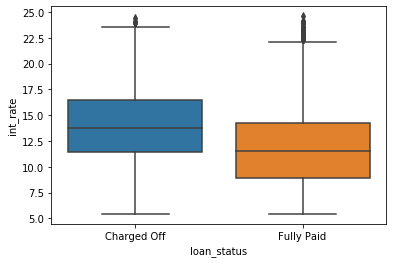

In [6]:
sns.boxplot(y="int_rate", x ='loan_status', data = df);

The difference between charged-off users and full-paid users in the distribution of `int_rate` is more drastic. The boxplot for fully-paid users is lower than the one for charged-off users. This result is as expected as higher interest rates would increase the actual amount of money a user have to pay.

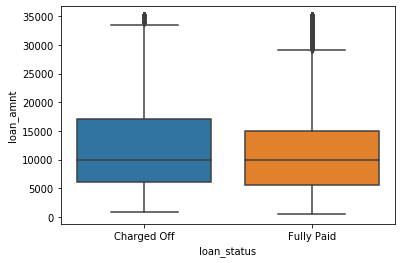

In [7]:
sns.boxplot(y="loan_amnt", x ='loan_status', data = df)

We don't see a clear change in the distribution of `loan_amnt`. Users who fully paid their debts seem to have slightly lower amount of loans on average.

#### Contingency tables and chi-squared testing

We expect that loan default behavior will also depend on the discrete variables. One way we can examine these relaitonships is by using **contingency tables** (cross tables) to summarize `loan_status` broken down by different variables. We use the function `crosstab(var1, var2)` to create these tables.

Let's write a function to generate contingency tables:

In [8]:
def get_ct(df, var):
    ct_res = pd.crosstab(df[var], df['loan_status'], margins=True)
    ct_res["Fully Paid(%)"] = round( ct_res["Fully Paid"]/ct_res["All"]*100, 2)
    return ct_res.drop(columns="All")

Then, we use this function to generate the contingency tables to examine the relationships between `loan_status` and all discrete variables in the dataset:

In [9]:
get_ct( df, 'verification_status')

loan_status,Charged Off,Fully Paid,Fully Paid(%)
verification_status,,,
Not Verified,2050,14449,87.58
Source Verified,1413,8406,85.61
Verified,1977,10410,84.04
All,5440,33265,85.94


In [10]:
get_ct( df, 'emp_length' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
emp_length,,,
< 1 year,641,3947,86.03
1 year,460,2787,85.83
2 years,571,3823,87.01
3 years,558,3540,86.38
4 years,466,2978,86.47
5 years,459,2826,86.03
6 years,309,1922,86.15
7 years,263,1512,85.18
8 years,206,1279,86.13


In [11]:
get_ct( df, 'home_ownership' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
home_ownership,,,
RENT,2752,15755,85.13
MORTGAGE,2268,14987,86.86
OWN,402,2443,85.87
OTHER,18,80,81.63
All,5440,33265,85.94


In [12]:
get_ct( df, 'purpose' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
purpose,,,
car,155,1344,89.66
credit_card,516,4491,89.69
debt_consolidation,2703,15572,85.21
educational,52,265,83.60
home_improvement,333,2554,88.47
house,59,310,84.01
major_purchase,211,1905,90.03
medical,101,569,84.93
moving,84,475,84.97


In [13]:
get_ct( df, 'term' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
term,,,
36 months,3073,25211,89.14
60 months,2367,8054,77.29
All,5440,33265,85.94


In [14]:
get_ct( df, 'grade' )

loan_status,Charged Off,Fully Paid,Fully Paid(%)
grade,,,
A,558,9136,94.24
B,1362,10335,88.36
C,1296,6642,83.67
D,1097,4116,78.96
E,710,2101,74.74
F,317,718,69.37
G,100,217,68.45
All,5440,33265,85.94


We can see from the contingency tables that some categorical variables likely have an impact on whether loans are paid off or not. 

We can formally test if the variations we observed indeed reflect actual differences or if they are just a byproduct of randomness. There are many different ways to perform the test but we will focus on the most widely used test: the **Chi-square test**. The null hypothesis for the Chi-square test is:

$$
H_0:\text{Primary Type is independent of Location Description}
$$

Lets use `chi2_contingency` to calculate the statistical significance of the variable associations seen in our contingency tables:

In [15]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['verification_status'], df['loan_status']))
print('verification_status: p-value of chisquare test =', p)

verification_status: p-value of chisquare test = 6.884998281535999e-17


In [16]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['emp_length'], df['loan_status']))
print('emp_length: p-value of chisquare test =', p)

emp_length: p-value of chisquare test = 0.06419956286286349


In [17]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['home_ownership'], df['loan_status']))
print('home_ownership: p-value of chisquare test =', p)

home_ownership: p-value of chisquare test = 3.094754275730736e-05


In [18]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['purpose'], df['loan_status']))
print('purpose: p-value of chisquare test =', p)

purpose: p-value of chisquare test = 6.53325963877868e-71


In [19]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['term'], df['loan_status']))
print('term: p-value of chisquare test =', p)

term: p-value of chisquare test = 2.7851291583847273e-194


In [20]:
chi2, p, dof, ex = chi2_contingency(pd.crosstab(df['grade'], df['loan_status']))
print('grade: p-value of chisquare test =', p)

grade: p-value of chisquare test = 0.0


It seems that all variables considered above are associated with `loan_status` since the proportions of fully-paid users are not the same across levels of these variables. Notably, the variable that we care about the most, `verification_status`, seems to have an counter-intuitive association with `loan_status`: the less reliable the income information is, the more likely a user would fully repay the debt, as reflected by the decreasing trend of fully paid proportions when `verification_status` increases from not verified to fully verified. The chi-square tests verify that all these observed associations, except for `emp_length`, are indeed statistically significant.

### Exercise 2: (5 min)

Based on the results above, which of the following statements are correct? Select all that apply.

1. There is a decrease of 2.5 on average in interest rate in users who fully paid their debts compared to users who didn't.
2. There is no statistically significant association between `emp_length` and `loan_status` since the proportion of fully paid users remains relatively the same across different levels of `emp_length`.
3. Since the chi-square test for the contingency table of `verification_status` vs. `loan_status` is significant, the decreasing trend of probability of pay-off is not likely due to randomness.
4. Since there is a significant difference between the probability of full payment in users with no verified income and users with verified income based on the chi-square test, we should always enforce income verification.

In order to introduce some of the concepts in this case, we'll start with a simplified question (rather than building a full model): **how important is income verification for loan approval?** 

If we want to know if `verification_status` really is associated with `loan_status` as indicated by the contigency table above, we should consider stratifying the contingency table between `loan_status` and `verification_status` by other variables that are also associated with `loan_status`.

### Exercise 3: (10 min)

Write a function to generate a contingency table for `verification_status` vs. `loan_status` stratified by `stra_var`. (Hint: If `index` includes two variables, the contingency table will be stratified by the first variable). Make sure to include a column for the proportion of fully-paid users in each level of `verification_status`. Use this function to examine the relationship between `verification_status` and `loan_status` when adjusting for `home_ownership` and `term`. Do we still see the same trend across different levels of `home_ownership` and `term`?

In [2]:
# fill in code to generate the contingency table

We can see the trend is preserved when stratified by `home_ownership`. The proportion of fully paid users decreases as the verification status gets less reliable regardless of levels of `home_ownership`. The exception is level `OTHER`. But since we have very few users there, we should not put too much confidence on the results. The trend is no longer preserved in both levels of `term`. We can see the proportion of fully paid users with shorter loan term (36 months) remains the same across different levels of `verification status` at around 88%.

## Logistic Regression (30 min)

From the chi-square test, we know that verification status is marginally associated with the probability of pay-off. We observed from the contingency table that this probability increases when the information about income becomes less reliable. However, this observation cannot be verified with just the standard chi-square test.

We introduce the logistic regression model to examine if this trend is significant. The logistic regression model is a modified version of the standard linear regression model that deals with classification problems, where the outcomes are binary variables (in this case, whether the loan was paid off or charged off). To understand a logistic regression model, let's first introduce the idea of odds. The odds of an event is the ratio of its success probability to its failure probability. In our case, the odds of fully paying the debt is defined as

$$
\text{Odds}(\text{Full payment}) = \frac{p}{1-p}.
$$

where $p$ is the probability of pay-off.

It turns out that it is easier to work with odds than probabilities. To investigate our question about trend in probability of pay-off $p$, we assume the odds is a function of income verification status:

\begin{equation}
\log(\text{Odds}) = \beta_0 + \beta_1*\text{verification_status}. \tag{1}
\end{equation}

In order to reflect that there is a trend over different verification statuses, we code different levels of `verification_status` using integers: "Not Verified" as 0, "Source Verified" as 1 and "Verified" as 2; i.e. we are renaming categories of a categorical variable to reflect a clear numerical trend. We assert that this coding scheme implies that if $\beta_1$ is positive, then there is an increasing trend of pay-off probability as income verification status becomes more reliable. On the other hand, if $\beta_1$ is negative, the opposite is true.

Once we fit the model in (1), we can perform a test to examine if $\beta_1$ is significantly different from zero. Note if $\beta_1=0$, then $p$ is the same for different levels of `verification_status` and thus no trend is present. If $\beta_1$ is significantly different from zero, we can use the estimated sign of $\beta_1$ to determine the direction of the trend.

### Numerical interpretation of logistic regression (5 min)

Although the logistic regression model comes with more complexity than standard linear regression, the sign of the regression coefficient still represents the direction of influence of a specific variable: a positive coefficient means the probability of pay-off will increase if the associated variable increases and vice versa.

The other important part of information when interpreting a logistic regression model is the $p$ - value for each regression coefficient. The p-value indicates the result of the following hypothesis test:

$$
H_0: \beta = 0~vs.~ H_A: \beta \neq 0.
$$

The test determines if the difference in the probability of pay-off is associated with changes in the corresponding variable.

Sometimes you might find that both the $p$ - value and the estimated effect size (regression coefficient) for a variable is small. You should be cautious about this situation as $p$ - values are not the only way to determine if variables are important.

### Fitting the logistic regression model (10 min)

We now fit the logistic model using the `statmodels` package with the specification we described above:

In [24]:
# code the discrete variable by the specification above
df_log1 = pd.DataFrame(columns=['verification_status','loan_status'])
df_log1['verification_status'] = df.verification_status.cat.codes
df_log1['loan_status'] = df.loan_status.cat.codes
df_log1['Intercept'] = 1

logit = sm.Logit(df_log1['loan_status'], df_log1[['Intercept','verification_status']])
logit_res = logit.fit()
print( logit_res.summary() )

Optimization terminated successfully.
         Current function value: 0.405007
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38703
Method:                           MLE   Df Model:                            1
Date:                Sun, 16 Feb 2020   Pseudo R-squ.:                0.002350
Time:                        19:42:28   Log-Likelihood:                -15676.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                 8.419e-18
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               1.9469      0.022     88.290      0.000       1.904       1.990
ve

This indicates that when `verfication_status` increases by 1, the odds of pay-off decreases by 14%. Since the $p$ - value for the coefficient is smaller than 0.05, we can conclude that the decreasing trend we observed from the table is not likely due to randomness.

An important output above is `Pseudo R-squ.`. This metric is similar to R-squared for linear models. If this number is large, then the variables in the model explain a large portion of the drivers of people's tendency to pay off their debt. In our case, the metric is only 0.2%, which means that we have a lot of room to improve.

#### Evaluating the numerical coding scheme for `verification_status` (5 min)

Note that our coding scheme assumes that the difference in the log-odds $p/(1-p)$ between people from any two consecutive levels of `verification_status` is the same. This assumption might be too strong and we ought to check if it is reasonable. We will fit the same model with a different coding scheme for `verification_status`. Instead of mapping levels to integers, we use dummy variables for different levels. With this specification, the difference in log-odds between two consecutive levels is not necessarily a constant. We set "Not Verified" as the reference level. The code and the results are shown below:

In [25]:
vs_dummy = pd.get_dummies(df.verification_status, drop_first=True)
vs_dummy.head()

,Source Verified,Verified
0,0,1
1,1,0
2,0,0
3,1,0
4,1,0


In [26]:
#vs_dummy = pd.get_dummies(df.verification_status, drop_first=True )
df_log1 = pd.concat([df_log1,vs_dummy], axis = 1)

logit_dummy = sm.Logit(df_log1['loan_status'], df_log1[['Intercept','Source Verified','Verified']])
logit_dummy_res = logit_dummy.fit()
print( logit_dummy_res.summary() )

Optimization terminated successfully.
         Current function value: 0.405001
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            loan_status   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38702
Method:                           MLE   Df Model:                            2
Date:                Sun, 16 Feb 2020   Pseudo R-squ.:                0.002366
Time:                        19:42:28   Log-Likelihood:                -15676.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                 7.140e-17
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.9528      0.024     82.741      0.000       1.907       1.999
Source Verifie

Based on the results, we can see the difference in log-odds between people from level "Source Verified" and level "Not Verified" is -0.16 while the difference between "Verified" and "Not Verified" is -0.28. The results confirm that the probability of pay-off is indeed decreasing when information of income becomes more reliable. But this also means that the differences in log-odds are not constant and the previous coding scheme might not be reasonable.

### Evaluating the logistic regression model (15 mts)

Remember that the goal of our whole analysis is to predict whether or not a user is going to pay off his debt. But how do we evaluate if the predication is accurate or not? This question is not as simple as it seems and the reason is because logistic models only produce probabilities while what we observed are binary labels.

A straightforward solution is that you can select a cut-off value for the predicted probability such that people with probabilities smaller than the cut-off value are deemed as defaulters. This converts the probabilities into binary labels, after which we can see if the predicted labels are the same as the observed labels to measure prediction accuracy.

However, this only takes into account a single cut-off value. We ought to summarize the prediction accuracy across all different cut-off values to produce a unified evalution of our model. For logistic models, this is usually implemented via the **receiver operating characteristic (ROC) curve**.

In order to understand a ROC curve, we need to first know the `true positive rate` (TPR) and `true negative rate` (TNR). In our context, TPR measures the proportion of people who paid off their debt that are correctly identified by our model, whereas TNR measures the proportion of defaulters that are identified as defaulters. Each point in the plot indicates the TPR and 1-TNR at a specific cut-off value.

There is a constant trade-off between TPR and TNR. It is usually hard to find a rule with high TPR and TNR at the same time. People will choose to prioritize one of them based on the particular scenario. For instance, in our case, TNR is usually more important than TPR since we would rather avoid lending to defaulters than miss lending to one good candidate.

The ROC curve plots TPR against 1-TNR and illustrates the behavior of a logistic model when the cut-off point changes. We can further summarize the whole ROC cruve by the **area under the curve (AUC)**. Roughly speaking, AUC indicates the probability that a randomly selected defaulter will have smaller $p$ than a randomly selected non-defaulter.

If AUC is close to one, the rule is close to a perfect rule. The ROC curve for a random guess rule (set $p$ to 0.5 for all applicants) is the diagonal line in the plot and usually serves as a baseline to check if the logistic model learns any information from the data above and beyond pure randomness. The ROC curves of the above two logistic regression models are shown below:

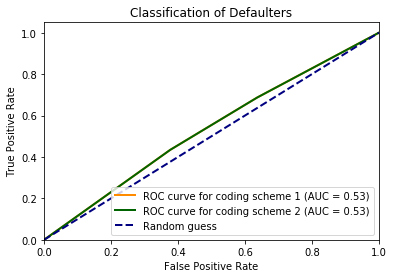

In [27]:
predict_p = logit_res.predict(df_log1[['Intercept','verification_status']])
predict_dummy_p = logit_dummy_res.predict(df_log1[['Intercept','Source Verified','Verified']])
roc_p = roc_curve(df_log1["loan_status"], predict_p)
roc_dummy_p = roc_curve(df_log1["loan_status"], predict_dummy_p)
auc_p = auc( roc_p[0], roc_p[1] )
auc_dummy_p = auc( roc_dummy_p[0], roc_dummy_p[1] )

plt.figure()
lw = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange',
         lw=lw, label='ROC curve for coding scheme 1 (AUC = %0.2f)' % auc_p)
plt.plot(roc_dummy_p[0], roc_dummy_p[1], color='darkgreen',
         lw=lw, label='ROC curve for coding scheme 2 (AUC = %0.2f)' % auc_dummy_p)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc="lower right")
plt.show()

From the figure we find that both ROCs have AUCs quite close to 0.5, confirming that `verification_status` alone is not very predictive of loan status above and beyond random guessing. This also confirms that the first coding scheme has identical performance to the second coding scheme. Since the first coding scheme is more parsimonious (i.e. contains fewer parameters) than the second scheme, we will use the first coding scheme for the rest of this analysis.

## Expanding the model (25 min)

In the previous section, we verified that there is indeed a decreasing trend in pay-off probability associated with more reliable income information. We also performed two model-checking approaches and determined that the integer coding for `verification_status` is adequate. Yet the discovered decreasing trend is counterintuitive. This might be because many other factors are also associated with the probability of pay-off as we have seen in the exploratory analyses. Similar to linear regression, not accounting for these factors will result in completely different answers for the effect of `verification_status`, which is already hinted at in the stratified contingency tables.

We find that except for `annual_inc`, all other variables in the dataset are correlated with `verification_status`. For example, there seems to be a strong correlation between `verification_status` and `loan_amnt`. People with no verified income source tend to borrow less money than people with verified income source. This might be the reason for the decreasing trend associated with `verification_status`, since smaller loans are more likely to be paid off. Let's now incorporate all these variables (including `annual_inc` for now) into the logistic model along with `verification_status` and see if the decreasing trend associated with `verification_status` is still present:

In [28]:
# Preprocessing the variables
df_log2 = pd.concat([(df.loan_amnt - df.loan_amnt.mean())/df.loan_amnt.std(),\
                     (df.int_rate - df.int_rate.mean())/df.int_rate.std(),\
                     (df.annual_inc - df.annual_inc.mean())/df.annual_inc.std(),\
                     pd.get_dummies(df.home_ownership, prefix="home", drop_first=True), \
                     pd.get_dummies(df.purpose, prefix="purpose", drop_first=True), \
                     pd.get_dummies(df.grade, prefix="grade",drop_first=True)], axis=1)
df_log2["verification_status"] = df.verification_status.cat.codes
df_log2["emp_length"] = df.emp_length.cat.codes
df_log2["term"] = df.term.cat.codes
df_log2["Intercept"] = 1

In [29]:
logit_full1 = sm.Logit(df.loan_status.cat.codes, df_log2)
logit_full1_res = logit_full1.fit()
print(logit_full1_res.summary())

Optimization terminated successfully.
         Current function value: 0.378075
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                38705
Model:                          Logit   Df Residuals:                    38676
Method:                           MLE   Df Model:                           28
Date:                Sun, 16 Feb 2020   Pseudo R-squ.:                 0.06869
Time:                        19:42:28   Log-Likelihood:                -14633.
converged:                       True   LL-Null:                       -15713.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
loan_amnt                     -0.0075      0.019     -0.389      0.697      

To help answer our original question (how important is income verification) we can build a logistic regression model without `verificaiton_status` included:

In [30]:
predict_withvs = logit_full1_res.predict(df_log2)
logit_full_novs = sm.Logit(df.loan_status.cat.codes, df_log2.loc[:, df_log2.columns != 'verification_status'])
predict_novs = logit_full_novs.fit(disp=0).predict(df_log2.loc[:, df_log2.columns != 'verification_status'])

and compare the ROC curves:

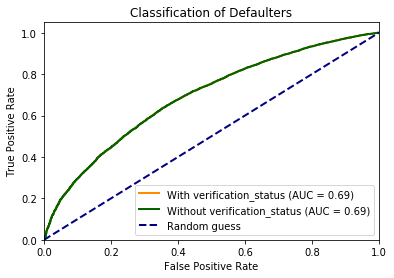

In [31]:
roc_vs = roc_curve(df.loan_status.cat.codes, predict_withvs)
roc_novs = roc_curve(df.loan_status.cat.codes, predict_novs)
auc_vs = auc( roc_vs[0], roc_vs[1] )
auc_novs = auc( roc_novs[0], roc_novs[1])

plt.figure()
lw = 2
plt.plot(roc_vs[0], roc_vs[1], color='darkorange',
         lw=lw, label='With verification_status (AUC = %0.2f)' % auc_vs)
plt.plot(roc_novs[0], roc_novs[1], color='darkgreen',
         lw=lw, label='Without verification_status (AUC = %0.2f)' % auc_novs)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc="lower right")
plt.show()

### Exercise 4: (5 min)

Based on all the results above, what can we conclude about the verification process?

### $k$-fold cross-validation (15 min)

We saw in Case 1 that a good way to estimate the performance of a trained model on new data is to split your data into training and test samples (cross-validation). We can extend this method by dividing the data set into $k$ partitions, performing cross-validation $k$ times using a different partition as the test set each time, and then averaging the $k$ trained models to predict final model performance. 

### Exercise 5: (10 min)

Generate the 10-fold cross-validation ROC curve (the average of all 10 ROC curves) and calculate the average AUC. Plot the cross-validation ROC curve, the training data ROC curve, and the random guess line on a single graph.

In [4]:
# fill in code to generate the 10-fold cross-validation ROC and AUC

In [3]:
# fill in code to plot the ROC and AUC

We can see the average AUC is a bit smaller than the AUC calculated with training data. The difference is small, indicating the overfitting problem is not material in our case. The cross-validation ROC curve is also very close to the ROC curve generated with training data, further strengthening our contention that we do not have an overfitting problem.

## The Naive Bayes classifier (50 min)

Although logistic regression is one of the most commonly used classification algorithms, it is not the only one. If the underlying relationship between the logit of odds and the covariates is not linear, we need to consider higher order terms of the covariates to make the logistic model valid. Doing so requires a lot of tuning and experimenting. In such cases, it is often better to look at a classification algorithm that does not rely on a specific assumption about the relationship between the probability of the outcome and the covariates. One such model is the **Naive Bayes classifier**.

### Conditional probability and Bayes theorem (5 min)

Naive Bayes depends on the concept of **conditional probability (CP)**. The conditional probability of event $A$ given event $B$ is defined as the probability of observing event $A$ provided that event $B$ has already happened. Numerically, this means:

$$
\text{CP($A$ given $B$)} = \frac{\text{P($A$ and $B$)}}{\text{P($B$)}}.
$$

Of course, there is nothing special about $A$ or $B$, so we can reverse them in the identity above to get:

$$
\text{CP($B$ given $A$)} = \frac{\text{P($B$ and $A$)}}{\text{P($A$)}}.
$$

Notice that the numerators on the right-hand side of both equations are identical. Therefore, we can equate them and substitute in the remainder of each identity to get:

$$
\text{CP($A$ given $B$)}\text{P($B$)} = \text{CP($B$ given $A$)}\text{P($A$)} \\
\rightarrow\text{CP($A$ given $B$)} = \frac{\text{CP($B$ given $A$)}\text{P($A$)}} {\text{P($B$)}} \\
$$

This is the famous **Bayes theorem**, upon which the Naive Bayes classifier is constructed.

### Exercise 6: (5 min)

Assume we know that the probability that a customer had no verified income source is 0.4, the probability of default is 0.5 and the conditional probability of default given the customer had no verified income source is 0.8. What is the probability of having no verified income given the customer is a defaulter?

### Introducing the algorithm (5 min)

Recall that in logistic regression, the main quantity of interest is the probability of default given specific values for the covariates. We explicitly modeled this probability as a linear function of covariates after transformation by the logit function.

The Naive Bayes classifier aims to estimate this probability from a different perspective. From the Bayes theorem, we can express this conditional probability in the following way:
$$
\text{CP(defaulter given covariates=values)} = \frac{\text{CP(covariates=values given defaulter)P(defaulter)}}{\text{P(covariates=values)}}.
$$

Therefore, if we can just estimate the values on the right-hand side, we can get what we want. Let's take a look at each of these quantities:

1. $\text{P(defaulter)}$. This is the probability of having a defaulter. It can be easily estimated as the proportion of defaulters in the dataset.
2. $\text{P(covariates=values)}$. This is the probability of having a customer whose covariates are equal to $\text{values}$. This can also be estimated by proportions, but we will actually find out that it is not necessary to estimate this quantity at all (more on this later).
3. $\text{CP(covariates=values given defaulter)}$. We can estimate this by looking at the proportion of defaulters with covariates equal to $\text{values}$. But if we have a lot of covariates, the number of such defaulters might be extremely small or even equal to zero. The main challenge in building a Naive Bayes classifier is estimating this particular probability.

Before we proceed to talk about the algorithm to estimate $\text{CP(covariates=values given defaulter)}$, let's first understand why, when the number of covariates is large, it is hard to estimate $\text{CP(covariates=values given defaulter)}$ by proportions directly: Assume we have 10 covariates and that all of them are binary variables. What is the minimum number of samples we need for it to be possible to have at least one sample for each possible combination of values of these covariates? We only need to calculate how many different possible values of covariates we can have when 10 binary covariates are present. The answer is $2^{10}=1024$ because each covariate has two different values and we have 10 covariates in total. So we need to have at least 1024 samples for it to even be possible to estimate $\text{CP(covariates=values given defaulter)}$.

### Why is the classifier "naive"? (5 min)

As we have seen above, we need a lot of samples to be able to estimate $\text{CP(covariates=values given defaulter)}$ for all possible $\text{values}$ using observed proportions. In order to get around this problem, the Naive Bayes classifier makes the assumption that *all covariates are independent when conditioned on the outcome*. This assumption might never be true in the real world, which is why the method is called "naive". Nonetheless, it usually does not severely hamper the tool in practice and gives quite powerful results a lot of the time.

In our case, the assumption implies that within defaulters/non-defaulters, all covariates are independently distributed:

$$
\text{CP(covariates=values given defaulter)} = \text{CP(covariate}_1\text{=value}_1\text{ given defaulter)}\times\cdots\times\text{CP(covariate}_p\text{=value}_p\text{ given defaulter)}
$$

Here we assume there are $p$ covariates in total. Let's see why it reduces the number of samples required to estimate proportions: Under the same assumptions as above, plus the independence assumption, we need to estimate $p$ simpler conditional probabilities and each one of them only concerns one binary variable, which has 2 possible outcomes. So we only need at least $2\times 10=20$ samples now, which is *much* smaller than $1024$.

With this assumption, we estimate $\text{CP(covariate}_1\text{=value}_1\text{ given defaulter)}$ to $\text{CP(covariate}_p\text{=value}_p\text{ given defaulter)}$ instead of $\text{CP(covariates=values given defaulter)}$. When the $\text{covariate}$ under consideration is discrete, we just need to estimate the proportions of its unique values in defaulters to get $\text{CP(covariate}\text{=value}\text{ given defaulter)}$.

### Exercise 7: (5 min)

Using the available data, estimate $\text{CP(term given defaulter)}$ and $\text{CP(verfication_status given defaulter)}$ for all different values of `term` and `verification_status`.

In [5]:
# fill in code to give the conditional probabilities of term and verification_status

When a covariate is continuous, the "proportion" of a given value is usually zero due to the continuous nature of the covariate. To get around this, we use the density of a covariate value to represent the conditional probability. The density depends on the distribution of the overall data; in the Naive Bayes classifier, we usually assume that the data is normally distribution (the second reason why it's naive). We then find the parameters of a normal distribution that is most closely aligned with the observed distribution of the covariate to get $\text{CP(covariate}\text{=value}\text{ given defaulter)}$.

We know that a normal distribution is uniquely determined by its mean and variance, so the normal distribution with mean equal to the sample mean and variance equal to the sample variance of the covariate is a good estimate to use. Once we get this normal distribution, the density can be calculated directly for any covariate value.

### Exercise 8: (5 min)

Find the normal distribution that most aligned with the observed distribution of `annual_inc` in defaulters. Based on this normal distribution, calculate $\text{CP(annual_inc=10,000 given defaulter)}$. Function `pdf()` in `scipy.stats.norm` 
calculates the density of a normal distribution at a given value.

In [6]:
# fill in code to find the normal distribution and fit the CP 

Once we have estimated all these single covariate conditional probabilities, we multiply them together to get our final estimate of $\text{CP(covariates=values given defaulter)}$. Now, we claim that we can use the following procedure to get $\text{CP(defaulter given covariates=values)}$:

1. Estimate $\text{P(defaulter)}$ and $\text{P(non-defaulter)}$.
2. Estimate $\text{CP(covariates=values given defaulter)}$ and $\text{CP(covariates=values given non-defaulter)}$
3. Estimate $\text{CP(defaulter given covariates=values)}$ with the following equation:

$$
\text{CP(defaulter given covariates=values)}=\frac{\text{CP(covariates=values given defaulter)}\text{P(defaulter)}}{\text{CP(covariates=values given defaulter)}\text{P(defaulter)}+\text{CP(covariates=values given non-defaulter)}\text{P(non-defaulter)}}
$$

### Exercise 9: (10 min)

Use the `boxplot()` function in the `seaborn` package to visualize the distribution of the following continuous variables: `loan_amnt`, `annual_inc` and `int_rate` in defaulters and non-defaulters. Do you spot any differences in the distributions in defaulters and non-defaulters? Do these seem to satisfy the assumptions of the Naive Bayes classifier? If not, what should you do to get them to conform?

In [8]:
# fill in code to plot the distribution of the continuous variables

We can see that the distribution of interest rate is different in the two types of users. The distribution of loan amount is also different, where non-defaulters tend to have more loans with small amounts (around 5000). The distributions of annual income seem to be heavily skewed, so let's apply a logarithmic transformation to see if we can get these to look more normal:

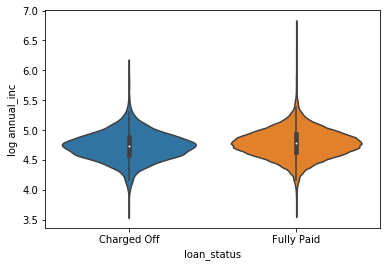

In [39]:
ax = sns.violinplot(x = df.loan_status, y = np.log10(df.annual_inc));
ax.set(ylabel='log annual_inc');

This is much better. The difference in annual income is not very large, but we can still see a slight increase in the mean of the annual income in non-defaulters compared to defaulters.

The distribution for `int_rate` is close enough to normal, but that of `loan_amnt` seems a bit skewed (although nowhere near the degree of `annual_inc`. Let's apply a square root transformation:

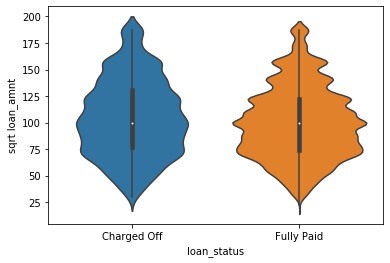

In [40]:
ax = sns.violinplot(x = df.loan_status, y = np.sqrt(df.loan_amnt));
ax.set(ylabel='sqrt loan_amnt');

This looks better.

From the above exercise, we find that we need to transform `annual_inc` and `loan_amnt` so that the normality assumption can be approximately satisfied. We will use the transformed variables to construct the Naive Bayes estimator:

In [41]:
df["annual_inc_log"] = np.log10(df.annual_inc)
df["loan_amnt_sqrt"] = np.sqrt(df.loan_amnt)

## Implementing the classifier (20 min)

We have seen that in order to estimate the classifier, we need to estimate the normal distribution that can be fit to each variable, then use this to estimate the probabilities we need. The below function `nb_fit_con()` will accomplish the first task:

In [42]:
"""
Learn parameters for continuous covariate
y is a binary outcome
X is a pandas series of a continuous covariate
"""
def nb_fit_con(y, X):
    y_code = y.cat.codes
    X_0 = X[y_code==0]
    X_1 = X[y_code==1]
    return [[np.mean(X_0), np.std(X_0)], [np.mean(X_1), np.std(X_1)]]

### Exercise 10: (5 min)

Write a function `nb_fit_dis` to estimate the probabilities of each level of a discrete covariate in defaulters and non-defaulters. The function returns a list of two lists. The first element contains probabilities in defaulters. The second element contains probabilities in non-defaulters.

In [9]:
# define the funciton here

The following function uses the two estimation functions we wrote above to train a Naive Bayes classifier:

In [44]:
"""
y is a binary outcome
X is a pandas dataframe of covariates
"""
def train_nb_classifier( y, X ):
    trained_model = {}
    for ind_col in X.columns:
        # check data type
        if X[ind_col].dtype=="float":
            params_fit = nb_fit_con(y, X[ind_col])
        else:
            params_fit = nb_fit_dis(y, X[ind_col])
        trained_model[ind_col] = params_fit
    margin_p_0 = np.sum(y.cat.codes==0)/len(y)
    trained_model["margin_p"] = [margin_p_0, 1-margin_p_0]
    return trained_model

Once the model is trained, the following function `predict_nb_classifier` predicts the probability of not defaulting for new samples:

In [45]:
"""
log of normal density
"""
def log_dnorm( x, loc, scale ):
    return -(x-loc)**2/2/(scale**2) - np.log(scale) - 0.5*np.log(2*np.pi)

"""
prediction
X_test: a pandas dataframe of covariates for prediction
        discrete vars have the same coding scheme as in the train dataset
"""

def predict_nb_classifier( nb_fit, X_test ):
    pred_0_p = np.ones( X_test.shape[0] )*np.log(nb_fit["margin_p"][0])
    pred_1_p = np.ones( X_test.shape[0] )*np.log(nb_fit["margin_p"][1])
    
    for ind_col in X_test.columns:
        params = nb_fit[ind_col]
        if X_test[ind_col].dtype=="float":
            #increment prob for outcome 0 for all samples
            update_0 = log_dnorm( X_test[ind_col], loc = params[0][0], scale = params[0][1] )
            update_1 = log_dnorm( X_test[ind_col], loc = params[1][0], scale = params[1][1] )
        else:
            update_0 = [np.log(params[0][x]) for x in X_test[ind_col].cat.codes]
            update_1 = [np.log(params[1][x]) for x in X_test[ind_col].cat.codes]
        pred_0_p = pred_0_p + update_0
        pred_1_p = pred_1_p + update_1
    
    #calculate the estimated probability of outcome=1
    #specifically handle Inf
    p_ratio = np.exp(pred_1_p-pred_0_p)
    p_1 = p_ratio/(1+p_ratio)
    p_1[p_ratio==np.Inf] = 1
    
    return p_1

### Exercise 11: (10 min)

Use functions `train_nb_classifier` and `predict_nb_classifier` to write a function to generate ROC curve and calculate AUC  for NB classifier with `n_split`-fold cross validation (refer to `cv_roc` for a template). The input should be `X`, the matrix of covariates, `y`, the vector of outcomes and `n_split`, the number of folds. The output is the same 3-tuple as function `cv_roc`, where the first element is the list of true positive rates across all `n_split` folds, the second element is a list of AUCs and the third element is a list of mean false positive rate which is set to be `np.linspace(0, 1, 100)`.  Use this function on the NB classifer with covariate `term`, `verification_status` and `annual_inc`. Compare this to the logistic model using the same set of covariates.

In [10]:
# write code to generate ROC curve and calculate AUC for the NB classifier

In [11]:
# fill in code to fit the NB classifier and compare the results to the logistic regression model

From Exercise 11, we can see that the Naive Bayes classifier has a slightly lower AUC than the corresponding logistic model. This might be due to the fact that these three covariates are highly correlated (as we have seen in the previous case). But the difference is not very large. Considering the fact that the Naive Bayes classifier is very easy to implement, we can still use it as a preliminary classifier.

## Decision trees and random forests (35 min)

Let's now discuss the **decision tree classifier**. The following figure shows an example. The nodes at the very bottom of the tree are called leaf nodes and all other nodes are called internal nodes or branch nodes. Each node contains a specific amount of samples that is indicated by `samples=`. Among these samples, the proportion of samples that are defaulters and non-defaulters are indicated by `value=`. The majority outcome values are indicated by `class=`.

When you want to predict the default status of a particular sample data point, you start with the top-most node. This internal node tells you which direction to go based on the value of `annual_inc`. Following the instructions in the internal nodes, you traverse the tree until you encounter a leaf node. The outcome label at that leaf node is then the predicted outcome for this sample. This whole prediction process is very much like what we do in our daily life when making a decision (based on the answer to a particular question, make a choice about what question to answer next and after enough answers, arrive at a conclusion).

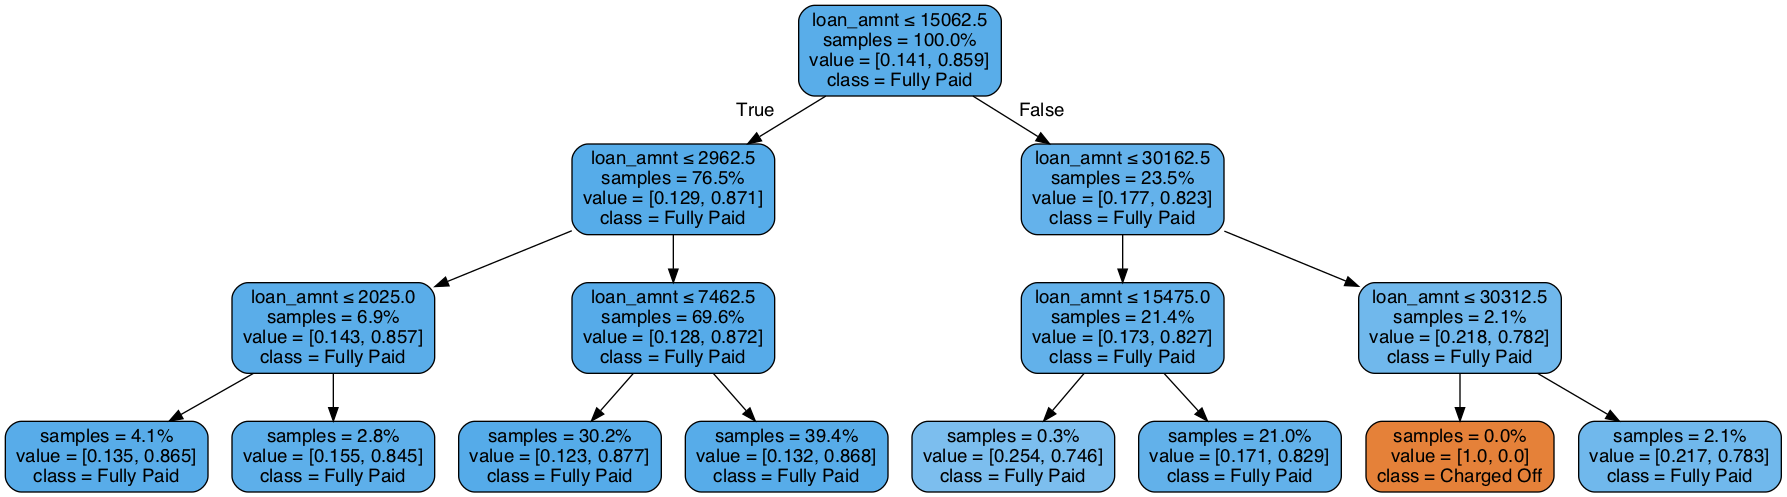

In [48]:
clf = DecisionTreeClassifier(max_depth = 3)

# Train Decision Tree Classifer
clf = clf.fit(df[["loan_amnt"]], df.loan_status.cat.codes)

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names = ["loan_amnt"],
                class_names=['Charged Off', 'Fully Paid'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity = False, proportion = True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Exercise 12: (5 min)

Assume you have two users with `annual_inc` equal to 10,000 and 100,000,000 respectively. What are the predicted default status for these two users, using the decision tree above?

We can see the decision tree approach does not put any assumption on the relationship between the outcome and the covariates. Therefore, it is a very flexible algorithm that can capture a wide range of underlying relationships between the outcome and the covariates. Nevertheless, this algorithm has many drawbacks:

1. Because it is so flexible, it tends to overfit. When applied to an independent validation set, the performance often decreases significantly. This drawback really limits the application of decision trees.
2. It is hard to train when the number of covariates are large. At each internal node, you need to scan through a long list of potential splitting variables, thus making the algorithm computationally cumbersome. However, this issue has been mitigated with modern computing power.
3. Decision trees trained on the same dataset are not always the same. This instability issue happens because the algorithm may not scan through the covariates in the same order every time. As a result, the final tree can vary a lot from run to run.

### Exercise 13: (5 min)

Use `train_test_split` function from `sklearn` package, randomly select 75% of the sample in our dataset and train a decision tree on these samples with covariate `annual_inc`. Evaluate the accuracy of the tree on the training set and samples that are not included in the training set. Do you see a significant change in the accuracy score?

In [12]:
# fill in code to split the dataset, train a decision tree, and evaluate the accuracy

We can see the accuracy drops 0.1 in the other samples. This seems to indicate the overfitting problem of our particular decision tree is not too severe. But we should keep in mind that the prevalence of non-defaulters in the dataset is much higher than that of defaulters. This might inflate the accuracy of an otherwise mediocre classifer. (To see an example of this, consider a naive classifier which labels everyone a non-defaulter. This classifier would be right the vast majority of the time, yet we would hardly consider it to be a nuanced classifier.)

### Decision boundary of a decision tree (5 min)

The decision boundary of decision tree can be highly non-linear. It usually looks like patches due to the fact that we are dichotomizing the dataset at multiple levels. The following is an example for a tree built with `annual_inc` and `loan_amnt`:

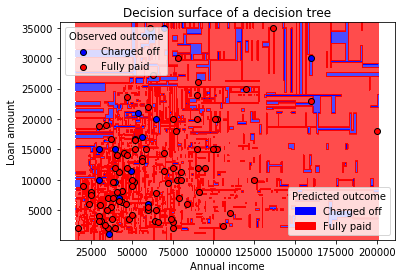

In [50]:
n_classes = 2
plot_colors = "br"

labels = ["Charged off", "Fully paid"]

clf = DecisionTreeClassifier().fit(df[["annual_inc","loan_amnt"]], df.loan_status.cat.codes)

# Plot the decision boundary
plot_step = 100
viridis = cm.get_cmap('viridis', 2)
newcolors = viridis(np.linspace(0, 1, 2))
blue = np.array([0, 0, 1, 1])
red = np.array([1, 0, 0, 1])
newcolors[0, :] = blue
newcolors[1, :] = red
newcmp = ListedColormap(newcolors)

np.random.seed(0)
idx_plot = np.random.choice(df.shape[0], 100, replace = False )
df_plot = df.iloc[idx_plot]

x_min, x_max = df_plot.annual_inc.min() - 1000, df_plot.annual_inc.max() + 1000
y_min, y_max = df_plot.loan_amnt.min() - 1000, df_plot.loan_amnt.max() + 1000
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))

fig, ax = plt.subplots()
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap=newcmp, alpha = 0.7)

plt.xlabel("Annual income")
plt.ylabel("Loan amount")
plt.axis("tight");

for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(df_plot.loan_status.cat.codes == i)
    plt.scatter(df_plot.iloc[idx].annual_inc, df_plot.iloc[idx].loan_amnt, c=color, 
                label=labels[i], edgecolors = "black")

legend_elements = [Patch(facecolor='blue', edgecolor='blue',
                         label='Charged off'),
                   Patch(facecolor='red', edgecolor='red',
                         label='Fully paid')]

plt.axis("tight")
plt.title("Decision surface of a decision tree")
leg1 = ax.legend(loc='upper left', title = "Observed outcome")
ax.legend(handles=legend_elements, loc = 'lower right', title = 'Predicted outcome');
ax.add_artist(leg1);

### Random forest to improve the performance of decision tree (15 min)

**Random forests** might well be the most popular machine learning algorithm for both classification and regression. The idea behind random forests is to construct a lot of decision trees, then use a voting mechanism to produce a final prediction that is agreed upon by most of the decision trees. When training these individual trees, we also subsample on the dataset as well as the covariates that are available in order to get as much built-in cross-validation as possible. As a result, the problem of overfitting and stability in a single decision tree model is resolved to a large degree. Let's fit a random forest classifier with covariates `term` and `annual_inc` and generate its ROC curve using the training data:

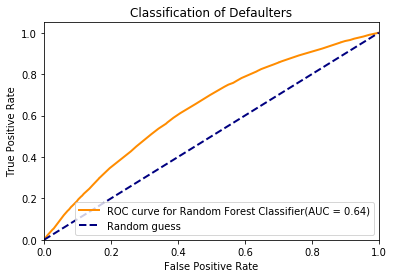

In [51]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)
clf_rf.fit( df_log2[['annual_inc','term']], df.loan_status.cat.codes )
clf_rf_probas = clf_rf.predict_proba(df_log2[['annual_inc','term']])

roc_p = roc_curve(df.loan_status.cat.codes, clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
lw = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange',
         lw=lw, label='ROC curve for Random Forest Classifier(AUC = %0.2f)' % auc_p)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Defaulters')
plt.legend(loc="lower right")
plt.show()

### Exercise 14: (10 min)

Use `cv_roc` as the template (same input arguments plus an argument `algo` determining decision tree or random forest, same output) to write a function `cv_roc_tree` that generates a 5-fold cross-validation ROC for a decision tree model and a random forest model with covariates `term` and `annual_inc`. Do you spot a significant increase in the prediction performance of the random forest model compared to the decision tree model?

In [13]:
# fill in code to write the cv_roc_tree function

In [14]:
# fill in code to fit the models and compare performance

**Answer.** We can see there is an increase in AUC using the random forest algorithm. With only two covariates, we can achieve a rather significant increase in the performance. This difference would likely be more pronounced with more variables.

## Selecting the best model for predicting default status (10 min)

So far we have learned about four different classification models, their strengths and weaknesses, and how to impelement them. We are also equipped with a powerful model comparison tool, cross-validation, to get an objective evaluation for a classification model. Let's now construct all three models (we'll leave out decision tree for now, and just use random forest as both belong to the family of tree-based models) using all of our covariates. We want to compare their cross-validation ROC curves and AUC values to decide which should be the one that forms the user selection procedure for our company:

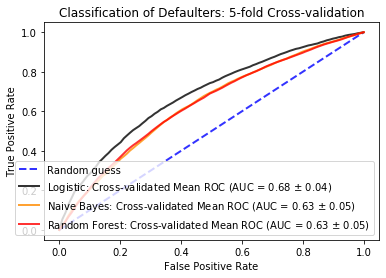

In [61]:
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue',
         label='Random guess', alpha=.8)

mean_tpr_nb = np.mean(tprs_nb, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_nb[-1] = 1.0
mean_tpr_f[-1] = 1.0

mean_auc_nb = auc(mean_fpr_nb, mean_tpr_nb)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
std_auc_nb = np.std(aucs_nb)
std_auc_f = np.std(aucs_f)

plt.plot(mean_fpr_vs, mean_tpr_vs, color='black',
         label=r'Logistic: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_vs, std_auc_vs),
         lw=2, alpha=.8)
plt.plot(mean_fpr_nb, mean_tpr_nb, color='darkorange',
         label=r'Naive Bayes: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_nb, std_auc_nb),
         lw=2, alpha=.8)
plt.plot(mean_fpr_f, mean_tpr_f, color='red',
         label=r'Random Forest: Cross-validated Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc_f, std_auc_f),
         lw=2, alpha=.8)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('Classification of Defaulters: 5-fold Cross-validation')
plt.show()

When deciding which model to use, the gold standard should always include the prediction performance; e.g. AUC. Aside from the performance, there are many other factors one should consider when choosing between these two models:

1. Purpose of the analysis. If a quick and dirty classifier is what we want, Naive Bayes is the one to go with as the implementation is rather straightforward and in most cases, it has similar performance as that of a logistic regression model.
2. Number of data points. In the era of big data it is common to encounter datasets with an enormous amount of samples. Since logistic regression is fit via an optimization routine, it can get very slow when the amount of data is large. The Naive Bayes classifier does not have this problem as it only calculates means and variances and is extremely fast even for large datasets.
3. Computing needs. As the number of covariates inceases, the computational burden of logistic regression grows much faster than linearly. Naive Bayes does not have this issue. Additionally, the random forest has identical performance but longer training time.

Based on the results above, we can pick either the logistic regression model or the Naive Bayes classifier as our final default detection model. In the future, if the amount of data required to be processed increases dramatically, we can prioritize the Naive Bayes model as a fast approximation to the logistic model. Sadly, random forest didn't improve performance, but this is mainly because we didn't tune the parameters in the random forest algorithm, which is a challenge in and of itself. There are situations where random forest is clearly the best model, but that is beyond the scope of this case.

## Conclusions (5 min)

In the first part of this case, we learned about several classification models: logistic regression, naive bayes, and random forests. We learned that the Naive Bayes classifier, although "naive", generally does not suffer much and in fact is the fastest to train. On the flip side, tree-based models and particularly random forest are able to capture many non-linear relationships and interactions in our data, but are much slower to train. We also learned about cross-validation and used it to select the model that has the best performance.

# Transition: Supervised vs Unsupervised Learning (5 mts)

The models we learned about above are all examples of 'supervised' machine learning. In supervised learning, the models rely on data which is well labled, meaning some or all of the data is already tagged with the correct answer. It is typicall used in the contexts of classification (where we want to map input to output labels) or regression (when we want to map input to a continuous output. 

Unsupervised models, on the other hand, learn about the inherent structure of data without using explicitly provided labels. The most common tasks in unsupervised learning are clustering, representation learning, and density estimation. In the second part of this case we will learn about one type of unsupervised learning model.

# Part Two: Unsupervised Learning

In [63]:
#import additional packages
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
import sklearn_extensions as ske
from sklearn_extensions.fuzzy_kmeans import KMedians, FuzzyKMeans

/Users/sthais/miniconda2/envs/c1_womens_summit/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


## Introduction (5 min)

**Business Context.** You are working for the fraud team at a large insurance company which deals with issuing insurance policies for various types of claims to both individuals and businesses. Policies which are issued are kept track of and any filed claims are examined and evaluated to determine legitimacy and final approval for pay out by the insurance company. However, many individuals attempt to take advantage, filing claims under false pretenses to obtain extra income. It is the role of the fraud team to determine which filed claims should be approved and which should be denied.

**Business Problem.** Your task is to answer the following question: **"Are there particular patterns in the groups of filed claims which may be indicative of fraud?"**

**Analytical Context.** The accounting team has provided you with data on all recent claims made by 1000 individuals. Unlike previous cases, the data here will be unlabeled; i.e. there is no variable that tells us which of these claims are fraudulent or not. As a result, the classification models we have been using up until now cannot be used, and we must instead use **clustering models** to tackle this **unsupervised learning** problem.

The case is structured as follows: we will   
1) perform exploratory data analysis to visually investigate the structure of the data  
2) use these observations to guide our clustering methodology and fit the appropriate models  
3) discuss the advantages and limitations of typical clustering methods  
4) segment and generate conclusions on particular clusters.

## Data exploration (15 min)

Let's start by importing the available data and looking at the first few rows:

In [65]:
# Importing the Data 
df_data = pd.read_excel('insurance_data_1000.xlsx')
df_data.head(5)

,case_id,income,age,sex,approval,fraud,claims
0,59982,35750.95,42,M,Approved,Under Review,9518.95
1,87249,24078.27,19,M,Denied,No,19354.23
2,50406,39241.52,37,M,Denied,Fraud,13056.04
3,59391,33248.31,26,M,Approved,No,19238.37
4,96622,38649.96,54,M,Approved,No,14427.42


In [66]:
# Interested in only a specific set of variables 
df_new = df_data[['case_id','income','age','claims']]
df_new.head(5)

,case_id,income,age,claims
0,59982,35750.95,42,9518.95
1,87249,24078.27,19,19354.23
2,50406,39241.52,37,13056.04
3,59391,33248.31,26,19238.37
4,96622,38649.96,54,14427.42


Next, let's take a look at the set of claims under review and how they are distributed:

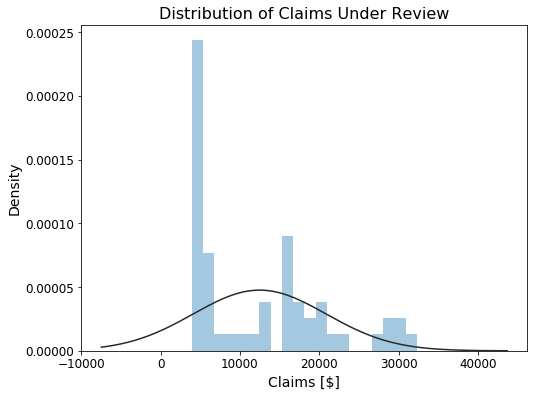

In [67]:
# These are cases labelled as under review 
%matplotlib inline
plt.figure(figsize=(8,6))
df_frauds=df_data[df_data['fraud']=='Under Review']
x=df_frauds['claims']
sns.distplot(x, bins=20, kde=False, fit=norm)
plt.title('Distribution of Claims Under Review', fontsize=16)
plt.xlabel('Claims [$]', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Density', fontsize=14)
plt.yticks(fontsize=12)
plt.show()

This is a really strange distribution. It seems like there are three sets of peaks for the claim amounts. Let's try to look at some 2D scatterplots of `claims` and `age` vs. `income` for the sample population, in order to glean more insight into what is going on:

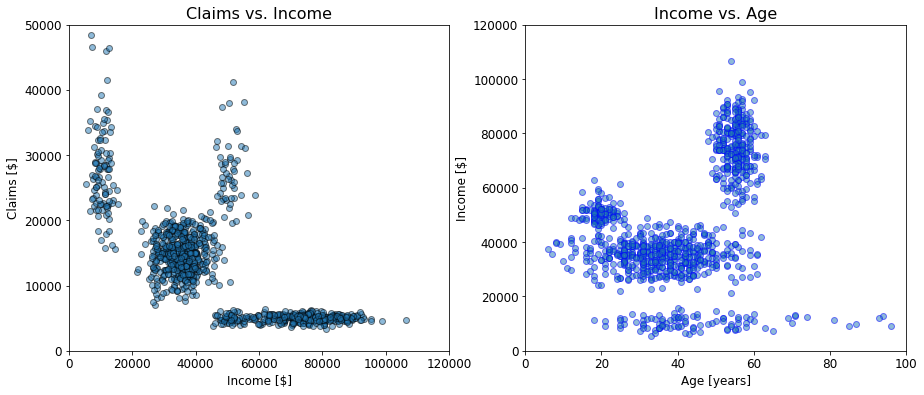

In [68]:
%matplotlib inline

f = plt.figure(figsize=(15,6))
fig = plt.subplot(121)
plt.scatter(df_new['income'], df_new['claims'], edgecolor='k', alpha=0.5)
plt.ylim(0, 50000)
plt.yticks(fontsize=12)
plt.ylabel('Claims [$]', fontsize=12)
plt.xticks(fontsize=12)
plt.xlim(0, 120000)
plt.xlabel('Income [$]', fontsize=12)
plt.title('Claims vs. Income', fontsize=16)

fig = plt.subplot(122)
plt.scatter(df_new['age'],df_new['income'], edgecolor='b', alpha=0.5)
plt.xlim(0, 100)
plt.xlabel('Age [years]', fontsize=12)
plt.xticks(fontsize=12)
plt.ylim(0, 120000)
plt.ylabel('Income [$]', fontsize=12)
plt.yticks(fontsize=12)
plt.title('Income vs. Age', fontsize=16)

plt.show()

We can also stratify our data by gender before performing the above visualizations:

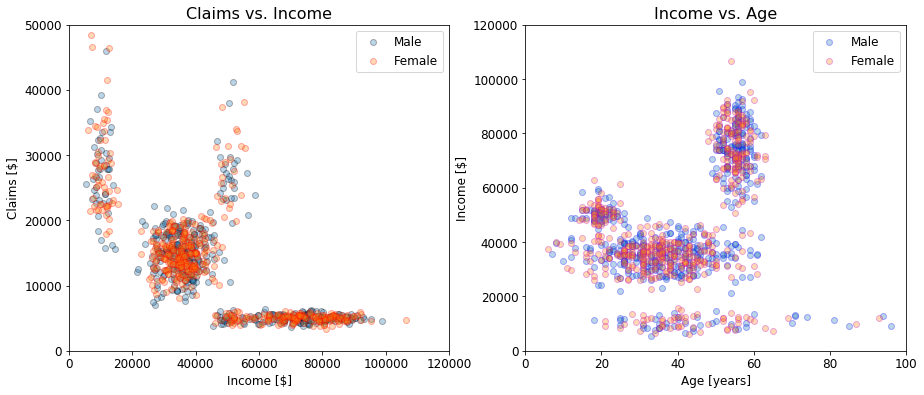

In [69]:
%matplotlib inline
df_gender = df_data[['case_id','income','age','claims','sex']]
df_male = df_gender[df_gender['sex']=="M"]
df_female = df_gender[df_gender['sex']=="F"]

f = plt.figure(figsize=(15,6))
fig = plt.subplot(121)
plt.scatter(df_male['income'], df_male['claims'], edgecolor='k', alpha=0.3, label="Male")
plt.scatter(df_female['income'], df_female['claims'], edgecolor='r', alpha=0.3, label="Female")
plt.legend(loc='best', fontsize=12)
plt.ylim(0, 50000)
plt.ylabel('Claims [$]', fontsize=12)
plt.xlim(0, 120000)
plt.xlabel('Income [$]', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Claims vs. Income', fontsize=16)

fig = plt.subplot(122)
plt.scatter(df_male['age'],df_male['income'], edgecolor='b', alpha=0.3, label="Male")
plt.scatter(df_female['age'],df_female['income'], edgecolor='m', alpha=0.3, label="Female")
plt.legend(loc='best', fontsize=12)
plt.xlim(0, 100)
plt.xlabel('Age [years]', fontsize=12)
plt.ylim(0, 120000)
plt.ylabel('Income [$]', fontsize=12)
plt.title('Income vs. Age', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

### Exercise 15: (5 min)

What patterns do you notice in the plots above? Why do you think these might be happening?

## $k$-means clustering (20 min)

In our visualizations above, there seem to exist distinct populations of individuals based on the relationships between claims and income, and income and age. However, we have only managed to investigate two relationships this way, and in larger datasets with many features, doing so manually across all variables can be very time-consuming. Luckily, **clustering models** allow us to summarize and detect potentially interesting relationships rather quickly.

There are many variations of clustering, but the most common, and the one we will be looking at, is called **$k$-means clustering**. This algorithm separates the given dataset into $k$ groups that minimizes the sum of the squares of distances between every pair of points in the group. The data scientist needs to pre-select the value of $k$, which may require prior analysis to determine.

The method has 3 broad steps, which can be summarized as follows:

1. Initialization. To start, one must select $k$ points (not necessarily any of the data points, just points in the same dimensional space) as the "initial" centroids.
2. Assignment. Each data point is assigned to the cluster corresponding to the centroid that is closest to itself (based on standard Euclidean distance).
3 Update. Once all data points have been assigned to their respective clusters, a new centroid is calculated for each cluster by taking the mean of all the points in that cluster.

Steps 2 and 3 are then repeated until the clusters no longer change.

### Exercise 16: (5 min)

$k$-means clustering relies on minimizing the Euclidean distance between data points. What sorts of problems might this pose in terms of the results we get? How might we fix this?

There are many ways of scaling, or **normalizing**, variables, one of which we have hinted at above. The best normalization choice depends on the particular details of the dataset at hand.

Similarly, the Euclidean distance is the most commonly used metric to compute the clusters, as it is quite easy to compute and performs well on most datasets, but it is not the only one. Data scientists sometimes use variations on the distance metric depending on the dataset they are investigating. Therefore, it is a parameter which should be considered and explored during the EDA stage to determine what is best to proceed with.

### Exercise 17: (10 min)

Write a function which will normalize `age`, `income`, and `claims` according to the minimum and maximum values of each variable. For example, if we are talking about `age`, then a normalized value for an age $A$ would be computed as $\displaystyle\frac {X - min(age)} {max(age) - min(age)}$. (This is known as the min-max scaling method.)

In [15]:
# fill in code to normalize variables and plot the normalized results 

### Exercise 18: (5 min)

Imagine a situation where in addition to our original dataset, there were a few high-income earners who also filed high-valued claims. What might go wrong with our scaling method above? How might you deal with this?

Let's also plot the normalized age vs. claims chart. Note that this one has 3 noticeable clusters instead of 4:

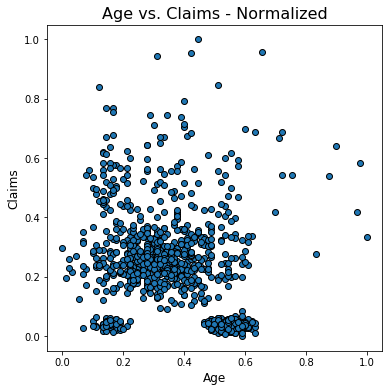

In [71]:
plt.figure(figsize=(6, 6))
plt.scatter(df_new_1['age'], df_new_1['claims'], edgecolor='k')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.xlabel('Age', fontsize=12)
plt.ylabel('Claims', fontsize=12)
plt.title('Age vs. Claims - Normalized', fontsize=16)
plt.show()

## Initialization of the clusters (15 min)

Based on the normalized data, we can make an educated assumption that we have 4 groups:

1. high incomes and low claims
2. moderate incomes and moderate claims
3. moderate incomes and high claims
4. low incomes and high claims

Let's investigate further to determine if this is the best way of clustering the data. We must start by initializing the first values of the centroids: 

Initial Centroids (income, claims) are: 
 {1: [-0.5, 1.0], 2: [1.0, 0.25], 3: [1.0, 1.0], 4: [-1.0, -0.25]}


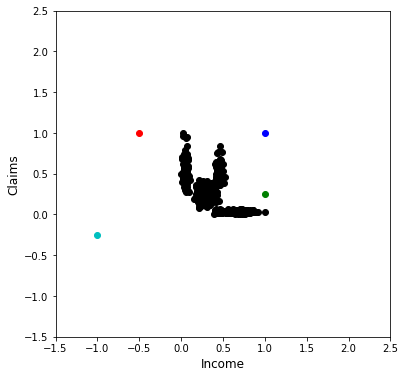

In [72]:
# Now we will begin our k-means method:

# Assign how many clusters (k-number) you would like to have
# This is only one implementation (crude) method of initializing the cluster centers

k = 4

# Manually selecting an x and y coordinate. 
data_range_x = [-1,-0.5,0.5,1]
data_range_y = [-1,-0.25,0.25,1]

centroids = {i+1: [np.random.choice(data_range_x), 
                   np.random.choice(data_range_y)] for i in range(k)}

print("Initial Centroids (income, claims) are: \n" ,
      centroids)

fig = plt.figure(figsize=(6, 6))
plt.scatter(df_new_1['income'], df_new_1['claims'], color='k')
colour_map_1 = {1: 'r', 2: 'g', 3: 'b' , 4:'c', 5:'y'}
for i in centroids.keys():
    plt.scatter(*centroids[i], color=colour_map_1[i])
plt.xlabel('Income', fontsize=12)
plt.ylabel('Claims', fontsize=12)
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2.5)
plt.show()

Here we've implemented a crude initialization of the cluster means, but the `KMean` package from `sklearn` already has the initialization preset to the most optimal method: "k-means++". We will work with this from here on out.

### Implementation of $k$-means using `sklearn` (5 min)

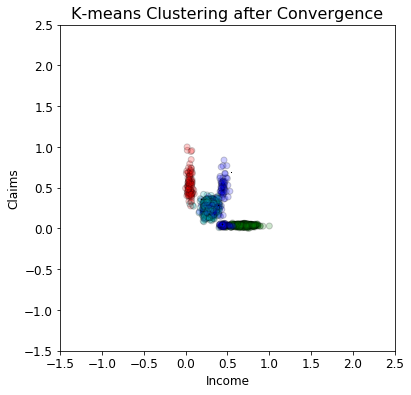

In [73]:
%matplotlib inline
k = 4
kmeans = KMeans(n_clusters=k,init='k-means++')
kmeans.fit(df_new_1)

# Iterative procedure to learn labels  
labels = kmeans.predict(df_new_1)
centroids = kmeans.cluster_centers_

# Plot the data learned
colour_map_1 = {1: 'r', 2: 'g', 3: 'b' , 4:'c', 5:'y', 6:'w'}
fig = plt.figure(figsize=(6, 6))
colors = [colour_map_1[x+1] for x in labels]

plt.scatter(df_new_1['income'], df_new_1['claims'], color=colors, alpha=0.2, edgecolor='k')

for idx, centroid in enumerate(centroids):
    plt.scatter(*centroid, color=colour_map_1[idx+1], marker='*', edgecolor='k')  # , s=150)
    
plt.xlabel('Income', fontsize=12)
plt.ylabel('Claims', fontsize=12)
plt.xlim(-1.5,2.5)
plt.ylim(-1.5,2.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('K-means Clustering after Convergence', fontsize=16)
plt.show()

## Selecting the optimal value for $k$ (25 min)

Even though visual analysis suggests that $k = 4$ is the optimal value, it is good practice to verify this quantitatively as opposed to just eyeballing it. (This is especially important when clustering data which cannot be easily visualized, a common occurrence with complex multidimensional data.)

### Exercise 19: (5 min)

How might you go about constructing a quantitative method for determining the optimal $k$?

The method described in Exercise 19 is a form of **regularization**; however, we are not ready just yet to get there. For now, we will be a little unscientific about this, instead leaving out the penalty term and looking for the value of $k$ on the line graph past which the change in sum of squares is effectively insignificant. This is called the *elbow method*.

### Exercise 20: (10 min)

Implement the elbow method scheme we described above. Does our initial guess of $k$ seem correct?

In [16]:
# fill in code to implement the elbow method

It would seem from the graph that the value of adding more clusters really starts to diminish around $k = 3$. $k = 4$ is very close to that, so we can say that our initial guess was on point (it's quite common for our visual guess and the output of the method above to be slightly different).

### Exercise 21: (5 min)

Given the four clusters of claims we identified based on the income vs. claims chart, and taking into account the information on the income vs. age chart, make a suggestion about what the department should do with each cluster.

### Exercise 22: (5 min)

Given what you have learned about the $k$-means algorithm, what are some potential drawbacks when it is applied to datasets?

## Conclusions (5 min)

In this case, we successfully split the dataset into 4 separate clusters, and validated our intuition based on $k$-means clustering. We learned that there are many built-in assumptions in $k$-means clustering (namely, the choice of distance metric, normalization, and $k$) and that this cannot easily be automated, as these choices depend on the particular dataset at hand. Once the individual groups have been identified, the insurance company can now determine which claims to give further investigation into or deem immediately as fraudulent based on some additional criteria.

## Takeaways (5 min)

Logistic regression, Naive Bayes, and tree-based models (decision trees and random forests) are all great classification models that each have their strengths and weaknesses. Cross-validation is an especially good way of evaluating the effectiveness of these models side by side.

Clustering is a powerful unsupervised learning tool for investigating non-labeled data, particularly for determining patterns which were not previously known or understood. In the case of large datasets, highly complex relationships may be identified among groups of individual data points that one could not possibly do via the human eye.